# Лабораторная работа №2. Моделирование данных MongoDB
## Задание.
1. Провести моделирование данных, подготовленных в  Лабораторной работе №1, для СУБД MongoDB
2. Провести импорт базы данных, реализованной в Лабораторной работе №1, в СУБД MongoDB. Импорт должен проводиться посредством программного кода, реализованного на выбранном студентом языке программирования. Скрипт (программа) импорта должна получать на вход данные для подключения к БД,  реализованной в Лабораторной работе №1, и  данные для подключения к БД MongoDB.
3. Реализовать программный код, проводящий тестирование корректности импорта.

Схема лаб.1 на картинке. Условия были:
Реализовать реляционную базу данных. Тема базы данных утверждается у преподавателя.

Структура базы данных должна содержать:
- главный объект;
- объект с отношением 1-1 с главным объектом;
- объект с отношением 1-N с главным объектом;
- объект с отношением N-M с главным объектом без характеристик связи;
- объект с отношением N-M с главным объектом с характеристиками связи;
- иерархическую структуру, связанную с одним из объектов.

Наполнить структуру данными. Каждая таблица должна содержать не менее 20 строк и отвечать требованиям 3 нормальной формы.

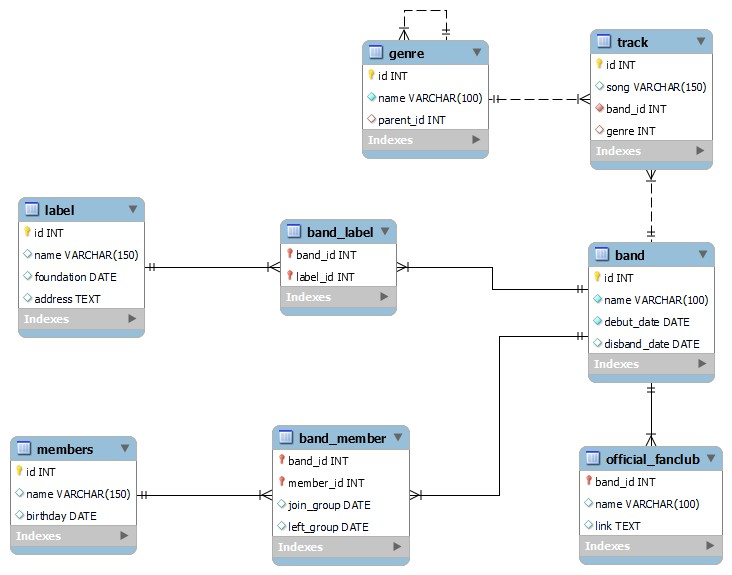

In [1]:
import mysql.connector
import pymongo
import random 
import copy
import datetime
import numpy as np
from faker import Faker
from mysql.connector import connect, Error
from queue import Queue
fake = Faker('ru_RU')
r_host = "localhost"
r_user = "root"
r_password = "aryuna"
r_db = "music_groups"
conn = connect(
    host=r_host, 
    user=r_user,
    password=r_password,
    database = r_db,
    port='3307'
)
cur = conn.cursor(dictionary=True)
m_host = "mongodb://localhost:27017/"
mong = pymongo.MongoClient(m_host)
mydb = mong[r_db]
band = mydb["band"]
mem = mydb["members"]
label = mydb['label']
genre = mydb['genre']
track = mydb['track']

In [32]:
cur.execute('SELECT name fanclub, link FROM official_fanclub')
fans = cur.fetchall()
cur.execute("SELECT id _id, name, CAST(debut_date AS datetime) debut_date, CAST(disband_date AS datetime) disband_date FROM band")
mains = cur.fetchall()
for i in range(len(mains)):
    mains[i]['official_fanclub'] = fans[i]
cur.execute('SELECT id _id, name, CAST(foundation AS datetime) foundation, address FROM label')
labels = cur.fetchall()
cur.execute('SELECT id _id, song, band_id, genre genre_id FROM track')
tracks = cur.fetchall()
cur.execute('SELECT id _id, name, CAST(birthday AS datetime) birthday FROM members')
mems = cur.fetchall()
cur.execute('SELECT id _id, name, parent_id FROM genre')
genres = cur.fetchall()

In [3]:
cur.execute("SELECT * FROM band_label ORDER BY band_id")
bl = cur.fetchall()
cur.execute("SELECT member_id, band_id, CAST(join_group AS datetime) join_group, CAST(left_group AS datetime) left_group FROM band_member ORDER BY member_id")
bm = cur.fetchall()

In [4]:
bl_ids = list({x['band_id'] for x in bl})
label_list = []
for i in bl_ids:
    label_list.append([i, {'label_id' : [x['label_id'] for x in bl if x['band_id']==i]}])

In [5]:
band.delete_many({})
label.delete_many({})
mem.delete_many({})
genre.delete_many({})
track.delete_many({})

In [6]:
band.insert_many(mains)
mem.insert_many(mems)
label.insert_many(labels)
genre.insert_many(genres)
track.insert_many(tracks)

In [7]:
for i in label_list:
    band.update_one({'_id' : i[0]}, {'$set' : i[1]})

In [8]:
cur.execute("SELECT member_id, band_id, CAST(join_group AS datetime) join_group, CAST(left_group AS datetime) left_group FROM band_member ORDER BY member_id")
bm = cur.fetchall()

In [9]:
band_list = []
m_ids = list({x['member_id'] for x in bm})
for i in m_ids:
    bamem = []
    bamem = [x for x in bm if x['member_id'] == i]
    r = copy.deepcopy(bamem)
    for t in range(len(r)):
        del r[t]['member_id']
    band_list.append([i, r])

In [10]:
for i in band_list:
    mem.update_one({'_id' : i[0]}, {'$set' : {'band(s)' : i[1]}})

In [11]:
def GetMongo(col):
    col_mongo = []
    for i in col.find():
        col_mongo.append(i)
    return col_mongo

In [62]:
def Check():
    global label_list
    global band_list
    band_mongo = GetMongo(band)
    fans_mongo = [x['official_fanclub'] for x in band_mongo]
    labels_mongo = GetMongo(label)
    track_mongo = GetMongo(track)
    mems_mongo = GetMongo(mem)
    genres_mongo = GetMongo(genre)
    checks = []
    label_list = np.array(label_list)
    for i in range(len(mains)):
        mains[i]['label_id']=label_list[:, 1][i]['label_id']
    band_list = np.array(band_list)
    for i in range(len(mems)):
        mems[i]['band(s)']=band_list[:, 1][i]
    checks.append(band_mongo==mains)
    checks.append(fans_mongo==fans)
    checks.append(labels_mongo==labels)
    checks.append(track_mongo==tracks)
    checks.append(mems_mongo==mems)
    checks.append(genres_mongo==genres)
    checks = np.array(checks)
    if checks.all() == np.full(len(checks), True).all():
        print("Отлично")
    return checks

In [13]:
band_mongo = GetMongo(band)
fans_mongo = [x['official_fanclub'] for x in band_mongo]
labels_mongo = GetMongo(label)
track_mongo = GetMongo(track)
mems_mongo = GetMongo(mem)
genres_mongo = GetMongo(genre)

In [34]:
label_list = np.array(label_list)
for i in range(len(mains)):
    mains[i]['label_id']=label_list[:, 1][i]['label_id']

In [45]:
band_list = np.array(band_list)
for i in range(len(mems)):
    mems[i]['band(s)']=band_list[:, 1][i]

In [63]:
Check()

Отлично


array([ True,  True,  True,  True,  True,  True])

    db.band.updateOne({_id : 1}, {$set : {'labels' : [2, 4, 5]}})
    db.band.updateOne({_id : 1}, {$set : {'labels' : [2, 4, 5]}})